# Кластеризация.

[Кластеризация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) - это один из видов задач обучения без учителя. Задача заключается в разбиении всех объектов на группы похожих между собой объектов и сильно отличающихся от всех остальных. Так как строгого понятия похожести объектов как такового нет, то алгоритмов кластеризации много, да и каждый алгоритм имеет много вариантов работы.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

## KMeans

Метод k-means - это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.
Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.
Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам: $$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$
Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости.
Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1. Этап кластеризации. На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2. Этап обновления центроидов. На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума, а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

_определение взято из материалов курса [ODS](https://habrahabr.ru/company/ods/)_

### Литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm
from skimage.io import imread

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Рассмотрим как работает алгоритм кластеризации KMeans на синтетическом примере.

Бросим на плоскость случайно точки с разными параметрами случайности, чтобы образовались кластеры.

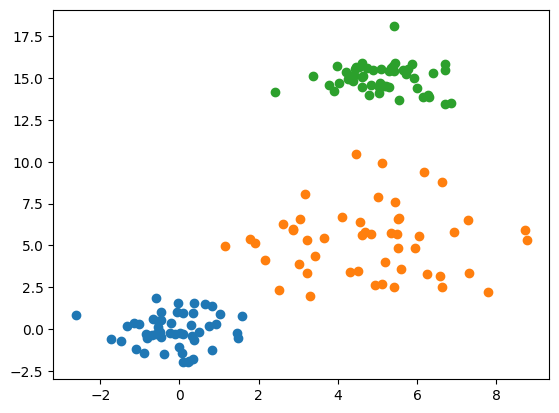

In [2]:
p1 = np.random.normal(loc=0, scale=1, size=(50,2))
p2 = np.random.normal(loc=5, scale=2, size=(50,2))
p3 = np.random.normal(loc=10, scale=0.8, size=(50,2)) - np.array([5, -5])

X = np.concatenate((p1, p2, p3))

plt.scatter(p1[:,0], p1[:, 1])
plt.scatter(p2[:,0], p2[:, 1])
plt.scatter(p3[:,0], p3[:, 1])

Нарисуем точки на плоскости, но без окрашивания точек. Так будет видеть данные алгоритм. Можем ли мы сами понять где и какие кластеры?

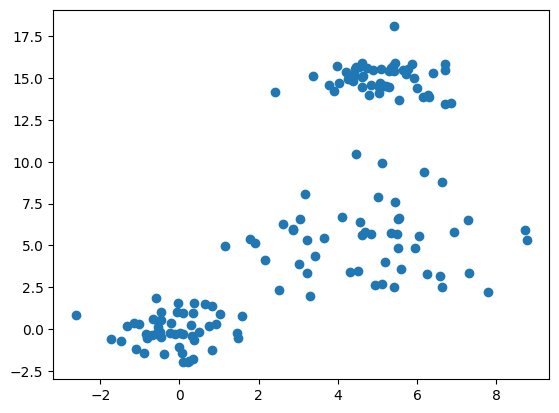

In [3]:
plt.scatter(X[:, 0], X[:, 1])

Рассмотрим пошагово работу алгоритма KMneans на основе обычного евклидова расстояния.  

_Пример из блога ODS: https://habrahabr.ru/company/ods/blog/325654/_

### Задание 1.1
Напишите функцию, которая рассчитывает расстояния от центров кластеров до каждой точки и возвращает, к какому кластеру принадлежит каждая точка.

In [4]:
from scipy.spatial.distance import cdist

def kmeans_predict(x, clusters):
    # Преобразуем список центроид в массив
    centroids = np.array(clusters)

    # Считаем расстояния от наблюдений до центроид
    distances = cdist(x, centroids, 'euclidean')

    # Находим индекс ближайшего центроида для каждой точки
    labels = np.argmin(distances, axis=1)

    return labels

# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
# Это сократит кол-во for и из-за этого код будет работать намного быстрее
# Но так нагляднее

Проверяем что получилось

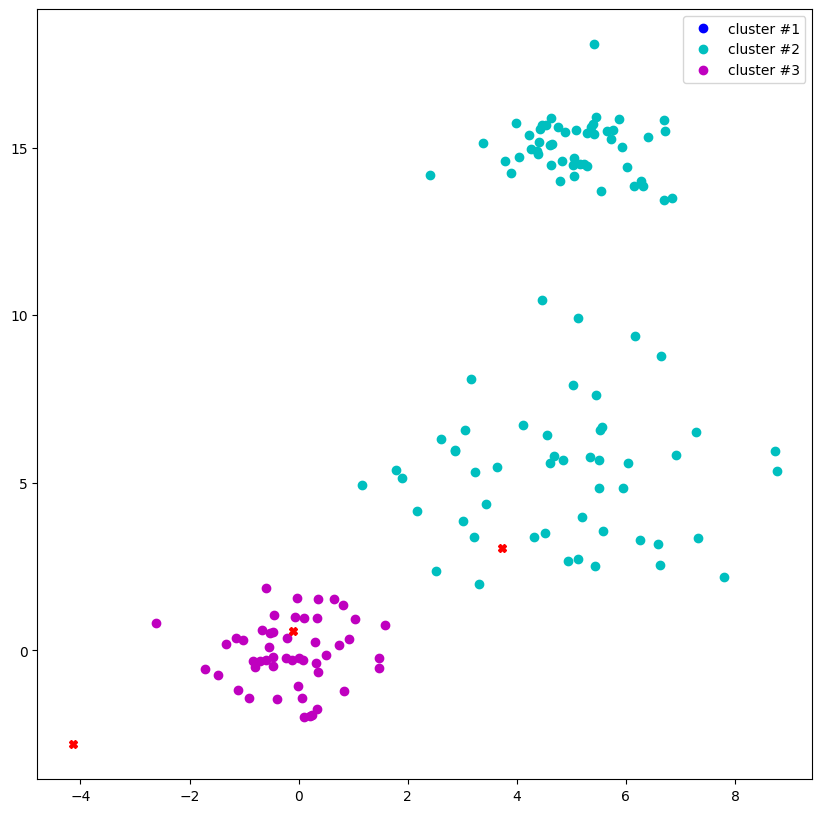

In [5]:
# Генерируем случайные координаты для центров кластеров
centroids = np.random.normal(loc=0.0, scale=5., size=6)
centroids = centroids.reshape((3, 2)) # итого получаем 3 точки в двумерном пространстве

plt.figure(figsize=(10, 10))
labels = kmeans_predict(X, centroids)

plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
plt.plot(centroids[:, 0], centroids[:, 1], 'rX')
plt.legend(loc=0)

###  Задание 1.2
Напишите код для обновления центров кластеров. Запоминайте центры кластеров $-$ это понадобится потом для визуализации.
Для упрощения каждому облачку данных заранее присвоим кластер.<br>
Положим в каждую новую центроиду геометрический центр её точек.<br>

In [6]:
centroids = np.random.normal(loc=0.0, scale=1., size=6).reshape((3, 2))

cent_history = [] # История центров кластеров
cent_history.append(centroids)

STEPS = 5 # количество шагов итерации обновления центров кластеров

for i in range(STEPS):
    # Получаем предсказанные метки для каждой точки
    labels = kmeans_predict(X, centroids)

    # Обновляем центроиды
    new_centroids = np.array([np.mean(X[labels == j], axis=0) for j in range(len(centroids))])

    # Сохраняем новые центроиды в историю
    cent_history.append(new_centroids)

    # Обновляем текущие центроиды
    centroids = new_centroids

А теперь нарисуем всю эту красоту

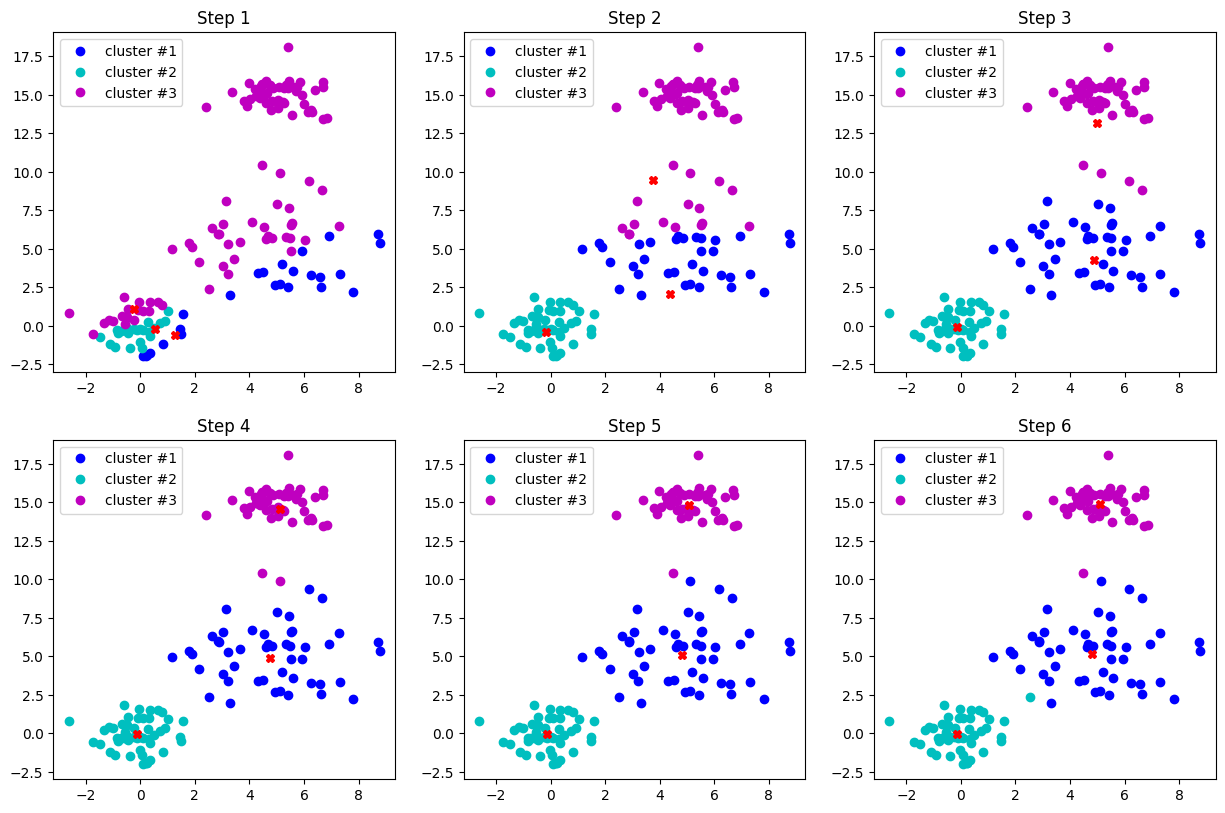

In [7]:
plt.figure(figsize=(15, 15))
for i in range(STEPS + 1):
    labels = kmeans_predict(X, cent_history[i])

    plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1))

Обратите внимание, последние 3 шага уже не сильно изменили координаты центров кластеров и состав кластеров.

### 1.3 Напишите функцию обучения kMeans, которая возвращает центры кластеров и к какому кластеру принадлежит каждая точка.

* k - кол-во кластеров
* max_iter - через сколько итераций остановится
* tol - если сумма расстояний между прошлыми центрами кластеров и новыми центрами меньше tol, то остановиться
* low и high - это минимально и максимально значение которое могут принимать точки центров кластеров при генерации

In [8]:
def kmeans_fit_predict(x, k=8, max_iter=100, tol=0.1, low=0.0, high=1.0):

    clusters = np.random.uniform(low=low, high=high, size=(k, x.shape[1]))

    # История центров кластеров
    cent_history = [clusters]

    for iter in range(max_iter):
        # Определение, к какому кластеру относится каждая точка
        labels = kmeans_predict(x, clusters)

        # Пересчет центров кластеров
        new_clusters = np.array([np.mean(x[labels == j], axis=0) if np.sum(labels == j) > 0 else np.random.uniform(low=low, high=high, size=(x.shape[1],)) for j in range(k)])

        # Считаем loss
        loss = np.sum(np.abs(new_clusters - clusters))

        # Выводим информацию о текущей итерации
        print(f"Iteration {iter + 1}, Loss: {loss}")

        # Проверяем критерий останова
        if loss < tol:
            print(f"Converged after {iter + 1} iterations.")
            break

        # Обновляем центроиды
        clusters = new_clusters

        # Сохраняем новые центроиды в историю
        cent_history.append(clusters)

    return clusters, labels

Проверим работу на точках: воспользуемся kmeans_fit_predict и построим график для результата предсказания кластеров.

In [9]:
# установим число кластеров k равное трем
# не генерируем центр кластера выше максимального значения из Х - ограничим это используя high
clusters_mnist, labels_mnist = kmeans_fit_predict(X, k=3, low=0.0, high=np.max(X))

Iteration 1, Loss: 33.775878360844054
Iteration 2, Loss: 14.87256534727673
Iteration 3, Loss: 5.264278766951529
Iteration 4, Loss: 1.6052062334873947
Iteration 5, Loss: 0.25933744459432034
Iteration 6, Loss: 0.0
Converged after 6 iterations.


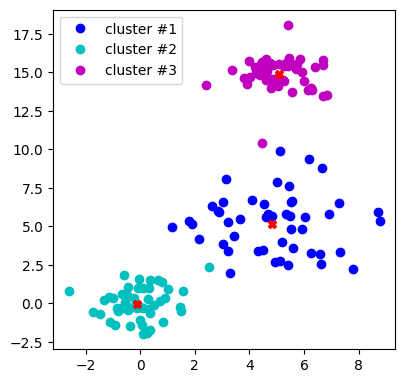

In [10]:
plt.figure(figsize=(15, 15))
plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
plt.plot(X[labels_mnist == 0, 0], X[labels_mnist == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels_mnist == 1, 0], X[labels_mnist == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels_mnist == 2, 0], X[labels_mnist == 2, 1], 'mo', label='cluster #3')
plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
plt.legend(loc=0)

## MNIST

Рассмотрим датасет рукописных цифр MNIST, с которым мы уже работали в задании по KNN.



In [11]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


Подумайте, как можно использовать kmeans для классификации

**Ваш ответ:** K-means можно использовать для кластеризации данных и поиска структуры в наборе данных, но в контексте классификации MNIST он имеет ограничения. В MNIST у нас есть 10 классов (цифры от 0 до 9), и k-means может не быть наилучшим выбором для задачи классификации с большим количеством классов. Однако, есть подходы, которые могут использовать результаты кластеризации k-means для обучения моделей классификации. Один из возможных способов:
1.   Исполь зовать k-means для кластеризации цифр на основе их изображений из MNIST.
2.   Затем можно присвоить метки кластеров каждому изображению в обучающем наборе.




Натренируйте kMeans используя функцию `kmeans_fit_predict()`, выберите high и low (как в примере с точками). Выберите подходящее число кластеров

In [12]:
clusters_mnist, labels_mnist = kmeans_fit_predict(X, k=10, max_iter=50, tol=0.1, low=np.min(X), high=np.max(X))

Iteration 1, Loss: 3258.4866592991993
Iteration 2, Loss: 1796.1995954718154
Iteration 3, Loss: 1552.6180434775729
Iteration 4, Loss: 1573.5787179579588
Iteration 5, Loss: 1422.5290161431499
Iteration 6, Loss: 1487.504927481311
Iteration 7, Loss: 1368.5459722556673
Iteration 8, Loss: 1446.2318252407877
Iteration 9, Loss: 1356.2085646061803
Iteration 10, Loss: 1260.6227990782968
Iteration 11, Loss: 1421.4196227856687
Iteration 12, Loss: 1378.299575129335
Iteration 13, Loss: 1374.554718646653
Iteration 14, Loss: 1222.1227239994578
Iteration 15, Loss: 1311.9079445707216
Iteration 16, Loss: 1415.120135402911
Iteration 17, Loss: 1374.7946273047392
Iteration 18, Loss: 1380.998324312368
Iteration 19, Loss: 1319.2055933454883
Iteration 20, Loss: 1427.8811901255858
Iteration 21, Loss: 1256.9488076795467
Iteration 22, Loss: 1382.3912580274573
Iteration 23, Loss: 1470.9003232467417
Iteration 24, Loss: 1346.9690350918522
Iteration 25, Loss: 1321.9877020631152
Iteration 26, Loss: 1304.3890511015998


Проверим. Выведем 10 точек из какого нибудь кластера и посмотрим, что они соотвествуют одной цифре.

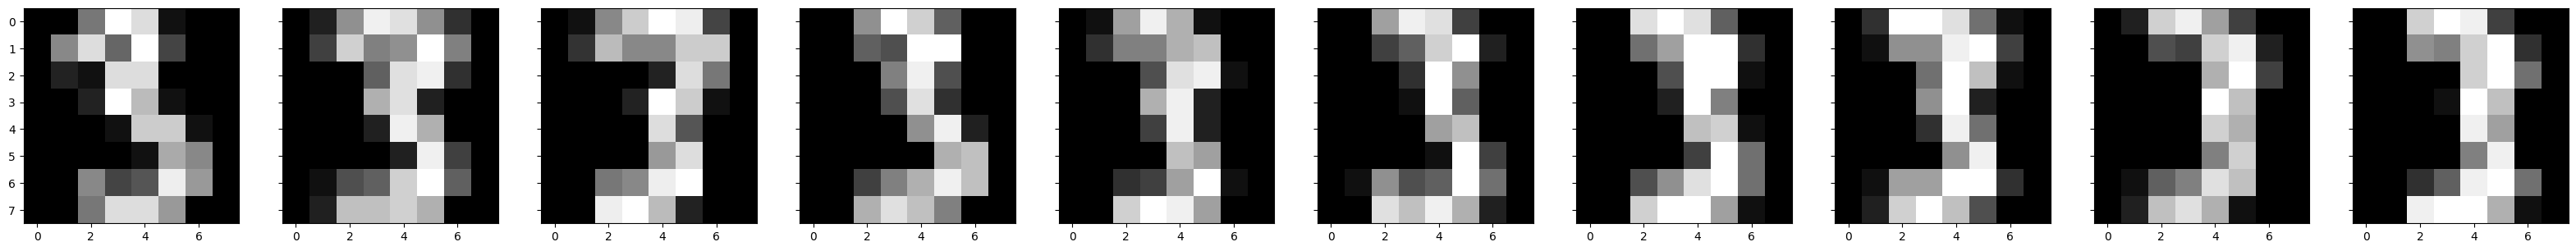

In [13]:
number = 3 # Номер кластера
count = 10 # Кол-во примеров
testX = X[y == number]

testX[0,:].reshape([8,8])
f, axes = plt.subplots(1, count, sharey=True, figsize=(40,6))
for i in range(count):
    axes[i].imshow(testX[i,:].reshape([8,8]), cmap='gray')

## Центры кластеров фотографий

Можно найти центры кластеров по фотографиям людей.

Возьмем фото 12 разных людей и разобьем их на кластеры. Так можно решать, например, задачу идентификации людей. Можно добавлять новое лицо и, не переобучая kmeans, определять, кто на этой фотографии (к какому кластеру относится картинка).

In [17]:
# загрузим датасет с фотографиями знаменитостей
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, resize=0.4)

Ariel Sharon: 77 photos.
Colin Powell: 236 photos.
Donald Rumsfeld: 121 photos.
George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.
Hugo Chavez: 71 photos.
Jacques Chirac: 52 photos.
Jean Chretien: 55 photos.
John Ashcroft: 53 photos.
Junichiro Koizumi: 60 photos.
Serena Williams: 52 photos.
Tony Blair: 144 photos.


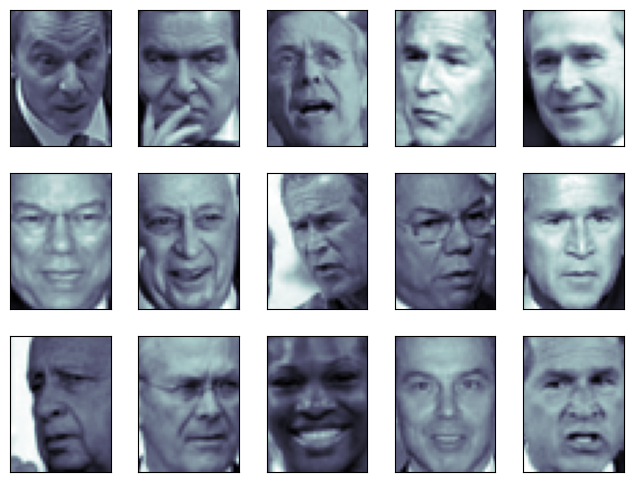

In [41]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

plt.show()

### 3.1 Натренируйте kMeans и нарисуйте центры кластеров как картинки выше.

Iteration 1, Loss: 5742.752303660446
Iteration 2, Loss: 654.7319946289062
Iteration 3, Loss: 304.3227844238281
Iteration 4, Loss: 189.95652770996094
Iteration 5, Loss: 126.7917251586914
Iteration 6, Loss: 109.44574737548828
Iteration 7, Loss: 82.65099334716797
Iteration 8, Loss: 71.5316162109375
Iteration 9, Loss: 64.82656860351562
Iteration 10, Loss: 62.71015930175781
Iteration 11, Loss: 51.191986083984375
Iteration 12, Loss: 36.69828414916992
Iteration 13, Loss: 37.94831848144531
Iteration 14, Loss: 38.176910400390625
Iteration 15, Loss: 27.704519271850586
Iteration 16, Loss: 18.881977081298828
Iteration 17, Loss: 17.233749389648438
Iteration 18, Loss: 24.053035736083984
Iteration 19, Loss: 22.070144653320312
Iteration 20, Loss: 22.726648330688477
Iteration 21, Loss: 6.3794450759887695
Iteration 22, Loss: 5.658201217651367
Iteration 23, Loss: 7.454816818237305
Iteration 24, Loss: 13.552120208740234
Iteration 25, Loss: 12.257891654968262
Iteration 26, Loss: 6.68826150894165
Iteration 

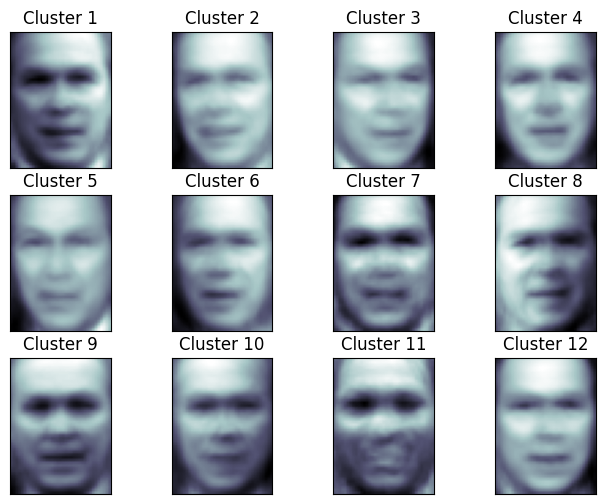

In [51]:
# Получение данных из датасета
X_faces = lfw_people.data
images_faces = lfw_people.images

# Применение kMeans
k = 12
clusters_faces, labels_faces = kmeans_fit_predict(X_faces, k=k, max_iter=50, tol=0.1, low=np.min(X_faces), high=np.max(X_faces))

# Визуализация центров кластеров как картинок
fig, axes = plt.subplots(3, 4, figsize=(8, 6), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(clusters_faces[i].reshape(images_faces.shape[1], images_faces.shape[2]), cmap='bone')
    ax.set_title(f'Cluster {i + 1}')

plt.show()

## Визуализация 64-мерного пространства, используя PCA и TSNE

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA - Метод главных компонент.

![](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

Далее мы будем использовать библиотеку [scikit-learn](http://scikit-learn.org/). По сути это библиотека-набор разных алгоритмов анализа данных, машинного обучения.

Документация по библиотеке всегда доступна:
- по ? в jupyter
- по комбинации shift-tab в jupyter
- на сайте http://scikit-learn.org/stable/documentation.html

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA -  [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

Нарисуем scatter plot для тренировочной выборки: на графике у нас будут точки, помеченные лейблом - цифрой которую обозначает эта точка в пространстве.

In [69]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


In [70]:
clusters_mnist, labels_mnist = kmeans_fit_predict(X, k=10, max_iter=50, tol=0.1, low=np.min(X), high=np.max(X))

Iteration 1, Loss: 3555.635099876441
Iteration 2, Loss: 887.4670915684491
Iteration 3, Loss: 513.7102040264178
Iteration 4, Loss: 463.5241658159356
Iteration 5, Loss: 477.37637756078686
Iteration 6, Loss: 452.1493153157504
Iteration 7, Loss: 467.7785966357853
Iteration 8, Loss: 396.4181182527229
Iteration 9, Loss: 369.14978455008566
Iteration 10, Loss: 309.8289148839242
Iteration 11, Loss: 293.8802577973966
Iteration 12, Loss: 335.9247780281645
Iteration 13, Loss: 350.17398747625714
Iteration 14, Loss: 341.5096588348065
Iteration 15, Loss: 403.8542889347484
Iteration 16, Loss: 351.52769740834356
Iteration 17, Loss: 332.82204135409
Iteration 18, Loss: 336.15146694345106
Iteration 19, Loss: 315.3700516274007
Iteration 20, Loss: 272.4317257971521
Iteration 21, Loss: 352.28354560425055
Iteration 22, Loss: 344.15370756871823
Iteration 23, Loss: 354.99222336541357
Iteration 24, Loss: 336.1797082045664
Iteration 25, Loss: 297.2502926608066
Iteration 26, Loss: 303.622155021699
Iteration 27, Lo

<ipython-input-71-caa0082fc291>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10), edgecolor='none', alpha=0.8, s=30,)


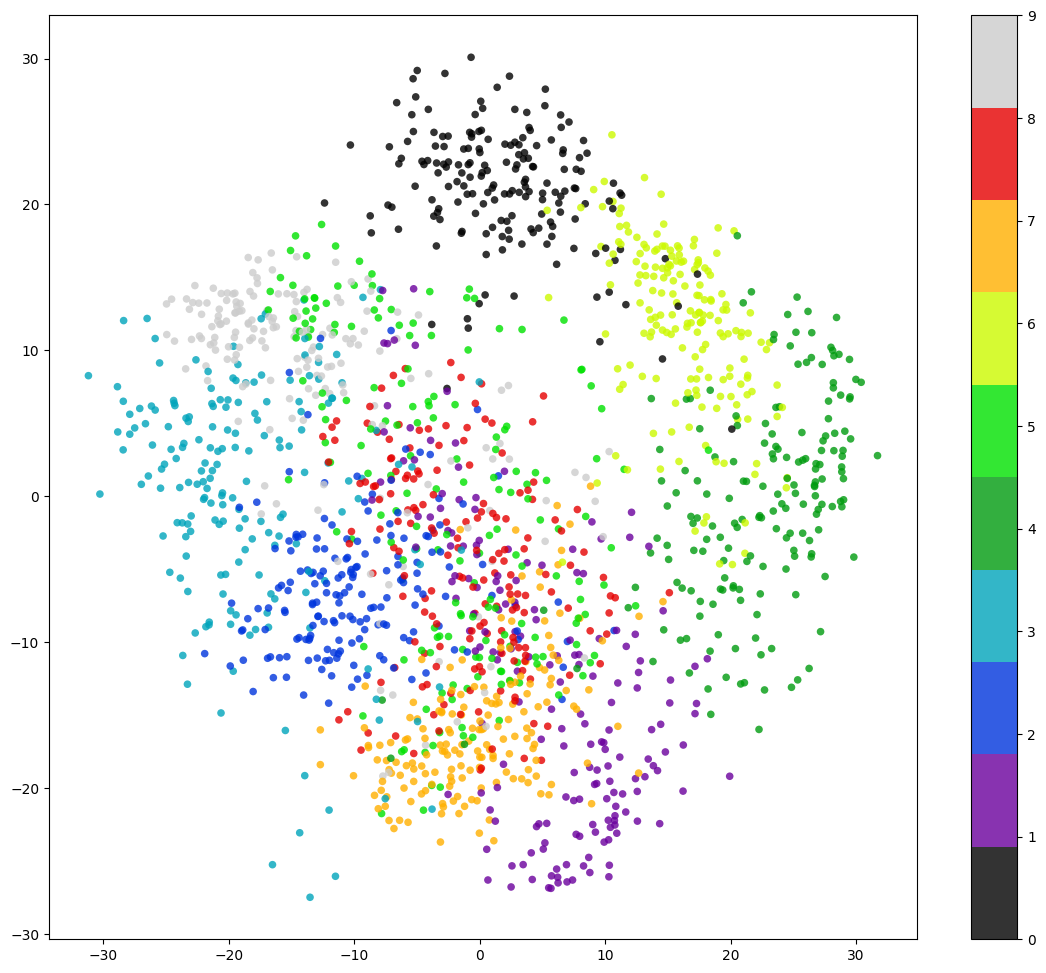

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42) # 2 компоненты, значит 2-мерное представление

X_reduced = pca.fit_transform(X)
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10), edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

А теперь посмотрим как расставил границы наш алгоритм KMeans. Как видим - хоть цвета и перепутаны, но сами кластеры угадываются.

<ipython-input-72-fd4ab01375b9>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels_mnist, cmap=plt.cm.get_cmap('nipy_spectral', 10),


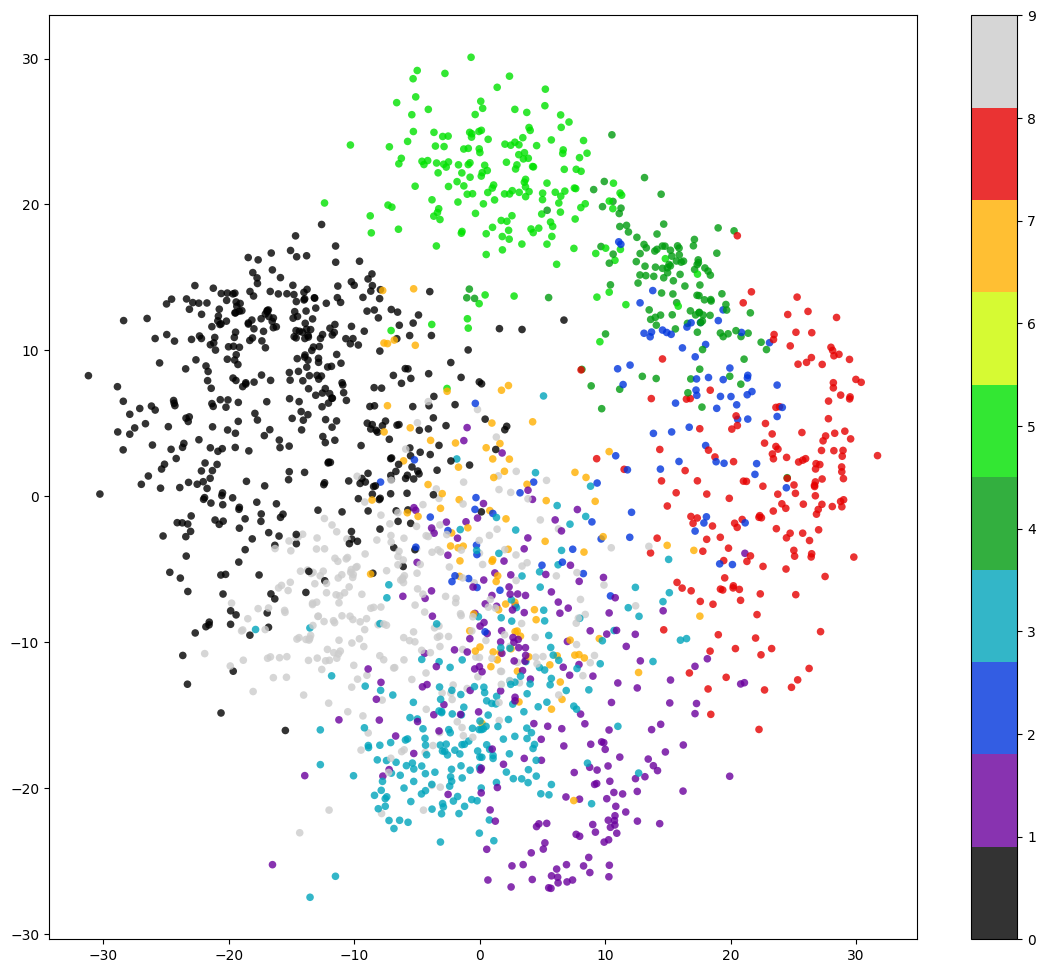

In [72]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels_mnist, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Центры кластеров представляют из себя нечто среднее, окруженное максимально "похожими" на них элементами. Поэтому мы можем предположить, что на визуализации, центры кластеров будут похожи на цифры.

Центры кластеров можно получить у модели лежат в `clusters_mnist`.

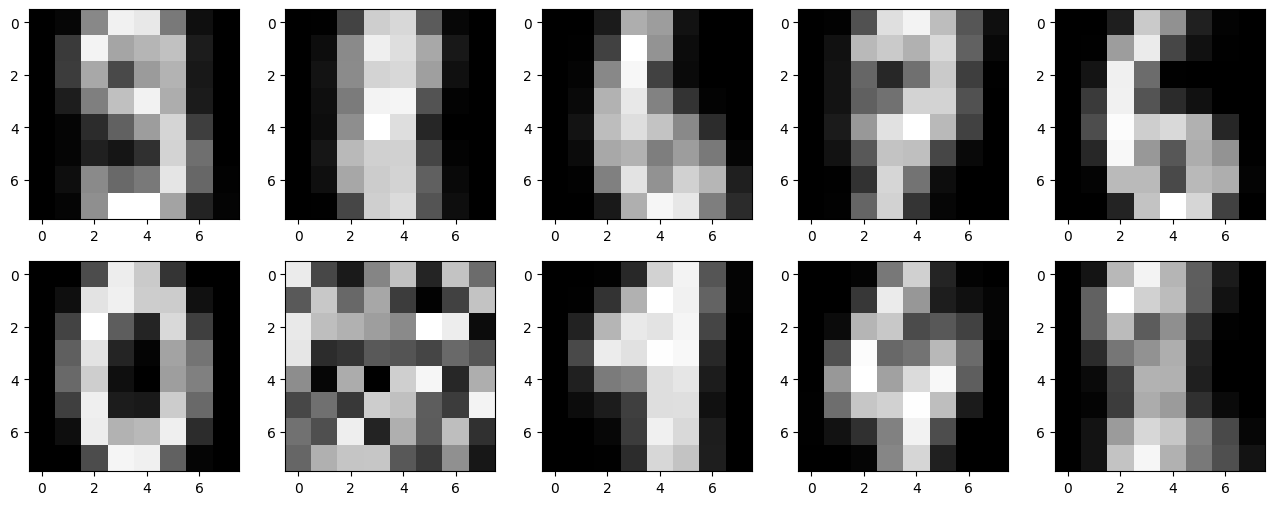

In [75]:
plt.figure(figsize=(16, 6))

for i, center in enumerate(clusters_mnist):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center[:].reshape([8,8]), cmap='gray')

Существуют и другие методы понижения размерности, например t-SNE, но он намного медленнее чем PCA.

Мы пока что не изучаем как именно работают PCA и tSNE, просто восхтимся их способностями.

<ipython-input-76-179e32a3b495>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),


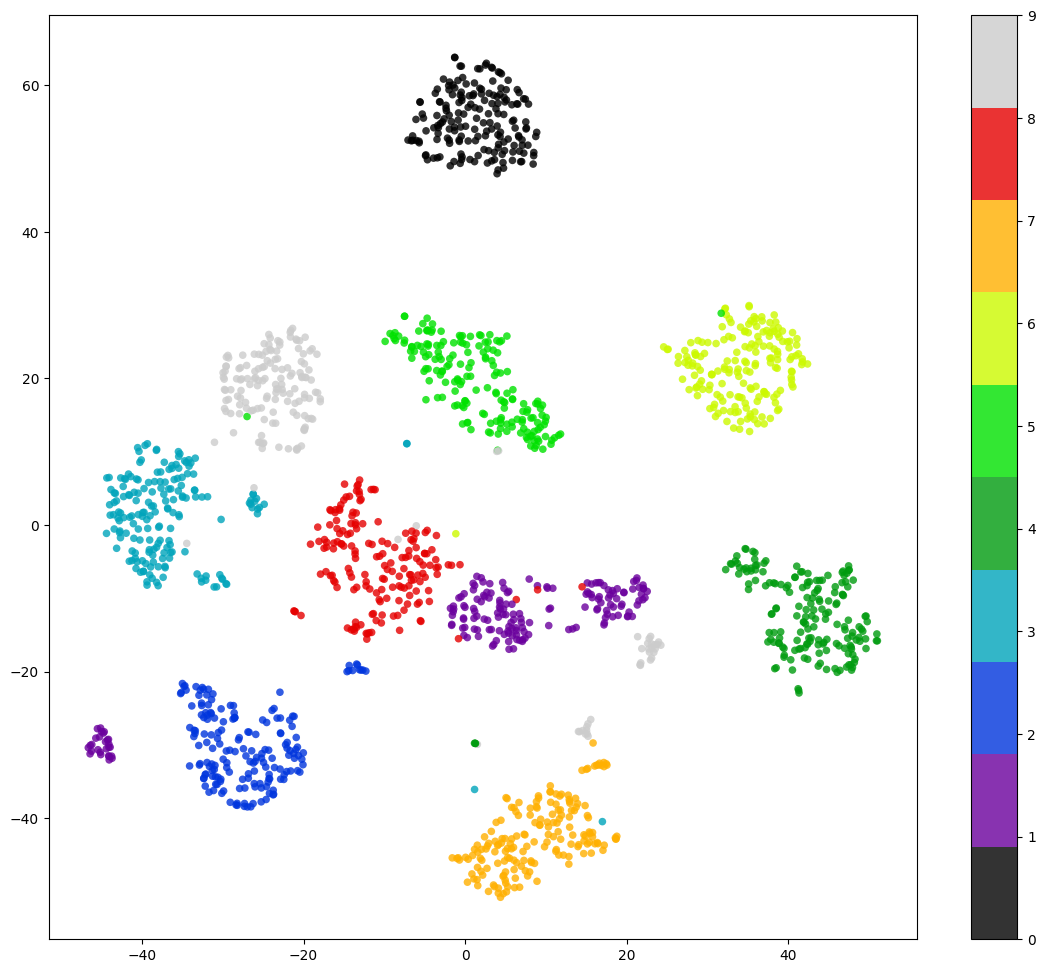

In [76]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_reduced_t = tsne.fit_transform(X)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Теперь нарисуем тот же scatter-plot, только на основе лейблов из kMeans. Ожидаем что кластеры будут покрашены в нужные цвета.

<ipython-input-77-0288bd16c88a>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=labels_mnist, cmap=plt.cm.get_cmap('nipy_spectral', 10),


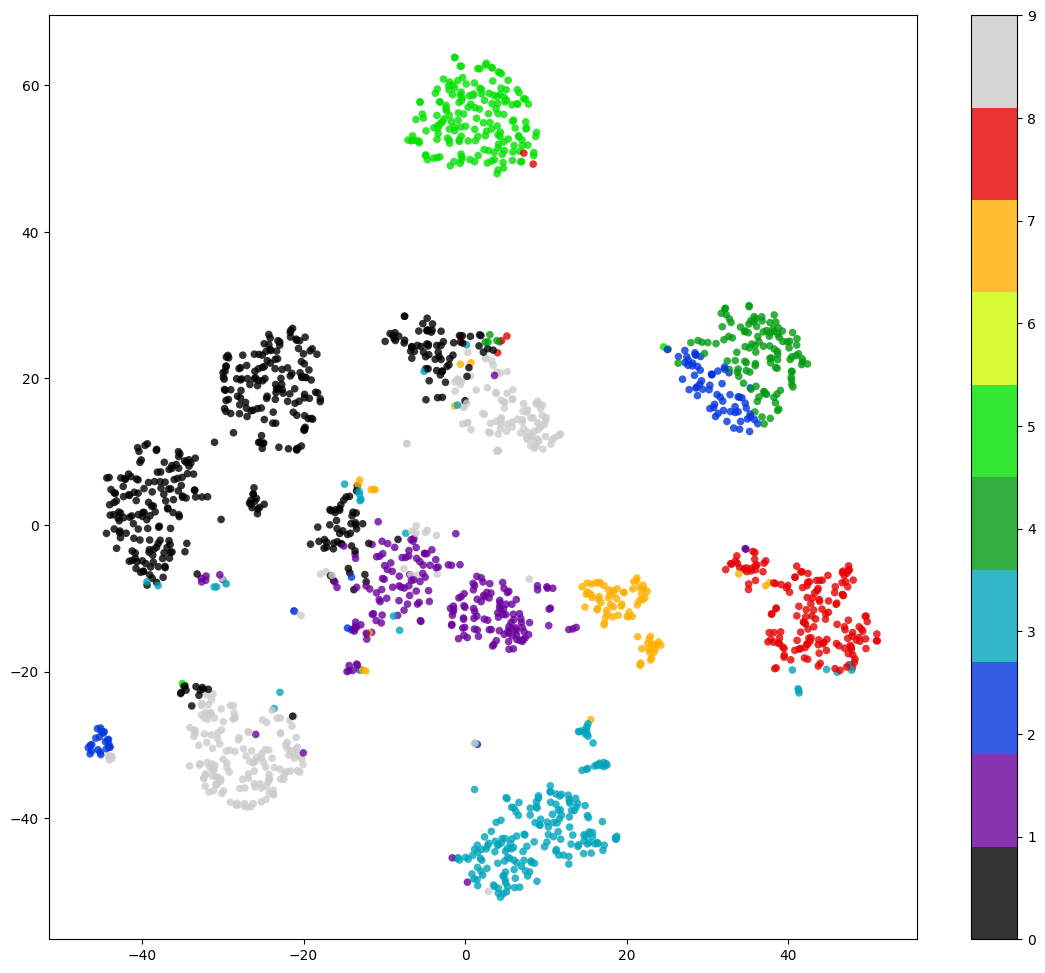

In [77]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=labels_mnist, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()